In [1]:
import os
import pickle
from metient.util import plotting_util as plutil
from metient.util.globals import *

REPO_DIR = os.path.join(os.getcwd(), "../../")


CUDA GPU: False


In [8]:
PARAMS = "calibrate_parsep1calandeval_12122023"
METIENT_OUTPUT_DIR = os.path.join(REPO_DIR, 'metient/data/tracerx_nsclc/metient_outputs')
ORCHARD_OUTPUT_DIR = os.path.join(METIENT_OUTPUT_DIR, 'pyclone_clustered_orchard_trees')
CONIPHER_OUTPUT_DIR = os.path.join(METIENT_OUTPUT_DIR, f'pyclone_conipher_{PARAMS}')
TRACERX_DATA_DIR = os.path.join(REPO_DIR, "metient/data/tracerx_nsclc/")


MONO_COLOR = "#6aa84fff"
POLY_COLOR = "#2496c8ff"

MAX_K = 5

In [13]:
import gzip
import torch

def get_patients(pickle_files_dir):
    patients = set()
    for file in os.listdir(pickle_files_dir):
        if ".pkl.gz" in file:
            name = file.split(".")[0].replace("_calibrate", "")
            patients.add(name)
    return patients

def patient_in_dict(dct, patient):
    for patient_primary in dct:
        if patient == patient_primary.split("_")[0]:
            return True, patient_primary, dct[patient_primary]
    return False, None, None

def is_better_pattern(old_patterns, new_patterns):
    for new_pattern in new_patterns:
        if "monoclonal" in new_pattern or "monophyletic" in new_pattern:
            return True
    return False


def get_info(pickle_files_dir):
    patients = get_patients(pickle_files_dir)
    seeding_patterns = dict()
    for patient in patients:
        with gzip.open(os.path.join(pickle_files_dir, f"{patient}.pkl.gz"),'rb') as f:
            pckl = pickle.load(f)
        Vs = pckl[OUT_LABElING_KEY]
        As = pckl[OUT_ADJ_KEY]
        idx_to_labels = pckl[OUT_IDX_LABEL_KEY]
        sites = pckl[OUT_SITES_KEY]
        primary_label =  "_".join(patient.split("_")[1:])
        tracerx_patterns = []
        patterns = []
        
        for x, (V, A, idx_to_label) in enumerate(zip(Vs, As, idx_to_labels)):
            if x > MAX_K:
                continue
            V = torch.tensor(V)
            A = torch.tensor(A)
            tracerx_pattern = plutil.get_tracerx_seeding_pattern(V, A, sites, primary_label,idx_to_label)
            pattern = plutil.get_verbose_seeding_pattern(V, A)
            #print(x, tracerx_pattern)
            tracerx_patterns.append(tracerx_pattern)
            patterns.append(pattern)
        # For patients with multiple primaries
        patient_name = patient.split("_")[0]
        if patient_name in seeding_patterns:
            prev_tracerx_pattern = seeding_patterns[patient_name][1]
            # choose the run with the primary that was more parsimonious
            if is_better_pattern(prev_tracerx_pattern, tracerx_pattern):
                seeding_patterns[patient_name] = patterns, tracerx_patterns
        else:
            seeding_patterns[patient_name] = patterns, tracerx_patterns

    print(f"{len(seeding_patterns)} patients")
    return seeding_patterns

### Load metient outputs using various combinations of clustering alg + tree inference alg + metient hyperparams

In [14]:
# (1) pyclone clusters + conipher trees + metient (maximum parsimony)
# conipher_mp_patterns, _ = get_info(os.path.join(CONIPHER_OUTPUT_DIR, 'max_pars'))

# (2) pyclone clusters + conipher trees + metient (maximum parsimony + genetic distance)
conipher_mp_gd_seeding_patterns = get_info(os.path.join(CONIPHER_OUTPUT_DIR, 'calibrate'))

# (3) pyclone clusters + orchard trees + metient (maximum parsimony)
# orchard_mp_seeding_patterns, _ = get_info(os.path.join(ORCHARD_OUTPUT_DIR, 'max_pars'))

# (4) pyclone clusters + orchard trees + metient (maximum parsimony + genetic distance)
# orchard_mp_gd_seeding_patterns, _ = get_info(os.path.join(ORCHARD_OUTPUT_DIR, 'max_pars_genetic_distance'))

inferred_patterns = conipher_mp_gd_seeding_patterns


126 patients


In [15]:
inferred_patterns

{'CRUK0572': (['monoclonal single-source seeding',
   'polyclonal primary single-source seeding',
   'polyclonal single-source seeding',
   'polyclonal single-source seeding',
   'polyclonal primary single-source seeding',
   'polyclonal primary single-source seeding'],
  ['monoclonal monophyletic',
   'polyclonal monophyletic',
   'polyclonal monophyletic',
   'polyclonal monophyletic',
   'polyclonal monophyletic',
   'polyclonal monophyletic']),
 'CRUK0762': (['polyclonal multi-source seeding',
   'polyclonal multi-source seeding',
   'polyclonal multi-source seeding',
   'polyclonal multi-source seeding',
   'polyclonal multi-source seeding',
   'polyclonal multi-source seeding'],
  ['polyclonal polyphyletic',
   'polyclonal polyphyletic',
   'polyclonal polyphyletic',
   'polyclonal polyphyletic',
   'polyclonal polyphyletic',
   'polyclonal polyphyletic']),
 'CRUK0559': (['polyclonal multi-source seeding',
   'polyclonal multi-source seeding',
   'polyclonal multi-source seeding'

### Get sample info

In [16]:
import pandas as pd
sample_info_df= pd.read_csv(os.path.join(TRACERX_DATA_DIR,"sample_overview_original.txt"), sep="\t")
print(sample_info_df.head())


  patient_id tumour_id             region  sampleType sampleTypeDetail
0   CRUK0010  CRUK0010  CRUK0010_SU_T1.R1     primary          primary
1   CRUK0010  CRUK0010  CRUK0010_SU_T1.R2     primary          primary
2   CRUK0010  CRUK0010   CRUK0010_SU_FLN1  metastasis               LN
3   CRUK0010  CRUK0010    CRUK0010_BR_LN1  metastasis  metachronousMet
4   CRUK0010  CRUK0010    CRUK0010_BR_LN2  metastasis  metachronousMet


### How often are samples monoclonal vs. polyclonal?

{'mono_poly': ['monoclonal', 'polyclonal', 'polyclonal', 'polyclonal', 'polyclonal', 'polyclonal', 'polyclonal', 'polyclonal', 'polyclonal', 'polyclonal', 'polyclonal', 'polyclonal', 'polyclonal', 'polyclonal', 'polyclonal', 'polyclonal', 'monoclonal', 'polyclonal', 'polyclonal', 'polyclonal', 'monoclonal', 'monoclonal', 'polyclonal', 'polyclonal', 'polyclonal', 'monoclonal', 'polyclonal', 'polyclonal', 'polyclonal', 'polyclonal', 'polyclonal', 'polyclonal', 'polyclonal', 'polyclonal', 'monoclonal', 'monoclonal', 'polyclonal', 'polyclonal', 'polyclonal', 'monoclonal', 'polyclonal', 'polyclonal', 'polyclonal', 'monoclonal', 'polyclonal', 'monoclonal', 'polyclonal', 'monoclonal', 'polyclonal', 'polyclonal', 'polyclonal', 'monoclonal', 'polyclonal', 'polyclonal', 'polyclonal', 'monoclonal', 'polyclonal', 'monoclonal', 'polyclonal', 'polyclonal', 'polyclonal', 'polyclonal', 'monoclonal', 'polyclonal', 'polyclonal', 'monoclonal', 'polyclonal', 'monoclonal', 'polyclonal', 'monoclonal', 'poly

/scratch/lsftmp/2424576.tmpdir/ipykernel_150837/3895821624.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  snsfig = sns.boxplot(x='mono_poly', y='num_samples', data=mono_poly_data, order=["monoclonal", "polyclonal"], linewidth=1.5, palette=palette, showfliers=True)
/lila/home/koyyald/mambaforge/envs/met/lib/python3.8/site-packages/seaborn/categorical.py:3370: UserWarning: 62.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/lila/home/koyyald/mambaforge/envs/met/lib/python3.8/site-packages/seaborn/categorical.py:3370: UserWarning: 55.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/lila/home/koyyald/mambaforge/envs/met/lib/python3.8/site-packages/statannot/statannot.py:555:

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04



AttributeError: module 'seaborn.categorical' has no attribute '_BoxPlotter'

<Figure size 640x480 with 0 Axes>

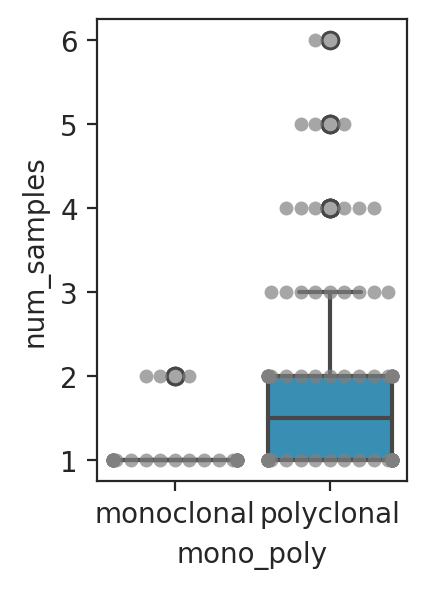

In [17]:
def get_num_met_samples(patient_id):
    sample_types = sample_info_df[sample_info_df['patient_id']==patient_id]['sampleType']
    return sample_types.value_counts()['metastasis']
    
mono_poly_data = {"mono_poly" : [], "num_samples" : [], "patient":[]}
for key, (patterns, tracerx_patterns) in inferred_patterns.items():
    patient = key.split("_")[0]
    pattern = patterns[0]
    tracerx_pattern = tracerx_patterns[0]
    # TODO: investigate these no seeding cases
    if (pattern.split()[0]=="no"):
        continue
    mono_poly_data['patient'].append(patient)
    mono_poly_data["mono_poly"].append(tracerx_pattern.split()[0])
    mono_poly_data["num_samples"].append(get_num_met_samples(patient))
print(mono_poly_data)
import seaborn as sns
import matplotlib.pyplot as plt
from statannot import add_stat_annotation

sns.set_style("whitegrid")
sns.set_style("ticks")
sns.despine()
fig = plt.figure(figsize=(2, 3), dpi=200)
palette = {"monoclonal":MONO_COLOR, "polyclonal":POLY_COLOR}
snsfig = sns.boxplot(x='mono_poly', y='num_samples', data=mono_poly_data, order=["monoclonal", "polyclonal"], linewidth=1.5, palette=palette, showfliers=True)
sns.swarmplot(x='mono_poly', y='num_samples', data=mono_poly_data, color="grey", dodge=False, alpha=0.7)  # Scatter plot
add_stat_annotation(snsfig, data=mono_poly_data, x='mono_poly', y='num_samples',
                    box_pairs=[("monoclonal", "polyclonal")], test='t-test_welch', text_format='star', loc='inside', verbose=1, fontsize=18, comparisons_correction=None)
plt.ylim(0, 6.5) 
plt.xlabel("Pattern")
plt.ylabel("Number of \nMetastasis Samples")
plt.xticks(rotation=45)
snsfig.spines['top'].set_visible(False)
snsfig.spines['right'].set_visible(False)
fig.savefig(os.path.join(REPO_DIR, "src/test/output_plots/tracerx", f"mono_vs_poly_num_samples_weight_exploration_{PARAMS}.png"), dpi=600, bbox_inches='tight', pad_inches=0.5) 

In [ ]:
sns.set(font_scale=1.9)
sns.set_style("whitegrid")
sns.set_style("ticks")
sns.despine()
fig = plt.figure(figsize=(4, 5), dpi=200)
palette = {"monoclonal":"#00A088", "polyclonal":"#3B5587"}

# Create a DataFrame
num_samples_df = pd.DataFrame(mono_poly_data)

# Define the num_sites ranges
num_samples_df['num_samples_range'] = pd.cut(num_samples_df['num_samples'], bins=[0, 2, 4, 6], labels=["1-2", "3-4", "5-6"])

# Calculate the proportions of monoclonal and polyclonal within each range
proportions = num_samples_df.groupby(['num_samples_range', 'mono_poly']).size().unstack(fill_value=0).div(num_samples_df.groupby('num_samples_range').size(), axis=0)

# Reset the index
proportions.reset_index(inplace=True)

# Create a stacked bar plot
ax1 = sns.barplot(x='num_samples_range', y='monoclonal', data=proportions, color=MONO_COLOR, label='monoclonal')
ax2 = sns.barplot(x='num_samples_range', y='polyclonal', data=proportions, color=POLY_COLOR, bottom=proportions['monoclonal'], label='polyclonal')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Add labels and legend
plt.xlabel("Number of \nMetastasis Samples")
plt.ylabel("Proportion of cases")
plt.title("")
plt.legend(title="",  loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)

# Show the plot
plt.show()
fig.savefig(os.path.join(REPO_DIR, "src/test/output_plots/tracerx", f"mono_vs_poly_prop_num_samples_weight_exploration_{PARAMS}.png"), dpi=600, bbox_inches='tight', pad_inches=0.5) 

In [ ]:
num_samples_df[["mono_poly", "num_samples_range"]].value_counts()

In [18]:
def get_source(p):
    '''
    {primary single-source, single-source, multi-source, reseeding, no seeding} 
    '''
    items = p.split()
    if len(items) == 4:
        return " ".join(items[1:3])
    if items == ["no", "seeding"]:
        return " ".join(items)
    return items[1]

### How concordant are our seeding patterns with TRACERx's?

In [19]:
tracerx_seeding = pd.read_csv(os.path.join(TRACERX_DATA_DIR, "seedingTable.txt"), sep="\t")
tracerx_seeding.columns = ["patient_id", "tracerx_clonality","tracerx_phyletic", "tracerx_multitree_adjustment"] 
print(len(tracerx_seeding))
from collections import OrderedDict

def get_metient_patterns(row, pattern_idx, is_phyletic):
    patient_id = row['patient_id'].split("_")[0]
    if patient_id not in inferred_patterns:
        print(patient_id)
        return "  "
    # make unique while preserving order
    patterns = list(OrderedDict.fromkeys(inferred_patterns[patient_id][pattern_idx]))
    if "no seeding" in patterns:
        print("no seeding", patient_id)
        return "  "
    clonalities = [pattern.split()[0] for pattern in patterns]
    if is_phyletic:
        sources_phyletics = [pattern.split()[1] for pattern in patterns]
    else:
        sources_phyletics = [get_source(pattern) for pattern in patterns]

    return ",".join(clonalities), ",".join(sources_phyletics)

tracerx_seeding['metient_tracerx_clonalities'] = tracerx_seeding.apply(lambda row: get_metient_patterns(row, 1, True)[0], axis=1)
tracerx_seeding['metient_tracerx_phyletics'] = tracerx_seeding.apply(lambda row: get_metient_patterns(row, 1, True)[1], axis=1)

tracerx_seeding['metient_clonalities'] = tracerx_seeding.apply(lambda row: get_metient_patterns(row, 0, False)[0], axis=1)
tracerx_seeding['metient_sources'] = tracerx_seeding.apply(lambda row: get_metient_patterns(row, 0, False)[1], axis=1)
tracerx_seeding

126
no seeding CRUK0666
no seeding CRUK0666
no seeding CRUK0666
no seeding CRUK0666


,patient_id,tracerx_clonality,tracerx_phyletic,tracerx_multitree_adjustment,metient_tracerx_clonalities,metient_tracerx_phyletics,metient_clonalities,metient_sources
0,CRUK0010,monoclonal,monophyletic,monophyletic,polyclonal,polyphyletic,"polyclonal,polyclonal","primary single-source,single-source"
1,CRUK0013,monoclonal,monophyletic,monophyletic,polyclonal,polyphyletic,polyclonal,primary single-source
2,CRUK0284,monoclonal,monophyletic,monophyletic,polyclonal,polyphyletic,polyclonal,primary single-source
3,CRUK0361,monoclonal,monophyletic,monophyletic,polyclonal,polyphyletic,polyclonal,primary single-source
4,CRUK0497,monoclonal,monophyletic,monophyletic,"polyclonal,monoclonal","polyphyletic,monophyletic","polyclonal,monoclonal","primary single-source,primary single-source"
...,...,...,...,...,...,...,...,...
121,CRUK0495,polyclonal,monophyletic,monophyletic,polyclonal,polyphyletic,polyclonal,primary single-source
122,CRUK0476,monoclonal,monophyletic,monophyletic,polyclonal,polyphyletic,polyclonal,primary single-source
123,CRUK0528,polyclonal,polyphyletic,polyphyletic,polyclonal,polyphyletic,polyclonal,primary single-source
124,CRUK0666,polyclonal,polyphyletic,polyphyletic,,,,


In [20]:
set(tracerx_seeding['patient_id']) - set(inferred_patterns.keys())

{'CRUK0084_Tumour2',
 'CRUK0301_Tumour1',
 'CRUK0372_Tumour1',
 'CRUK0620_Tumour1',
 'CRUK0721_Tumour1'}

In [21]:
inferred_patterns['CRUK0721']

(['polyclonal primary single-source seeding',
  'polyclonal primary single-source seeding',
  'polyclonal primary single-source seeding'],
 ['polyclonal polyphyletic',
  'polyclonal polyphyletic',
  'polyclonal polyphyletic'])

### How concordant are our characterizations of monoclonal/polyclonal with TRACERx

tracerx mono met mono 43
tracerx mono met poly 77
tracerx poly met poly 38
4
tracerx poly met mono 4


<Figure size 640x480 with 0 Axes>

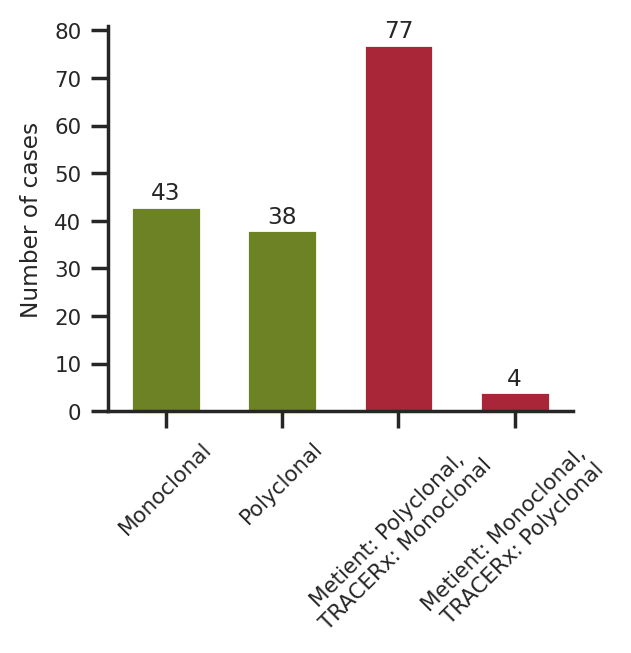

In [25]:

num_tracerx_mono_met_mono = len(tracerx_seeding[(tracerx_seeding['tracerx_clonality']=="monoclonal")&(tracerx_seeding['metient_tracerx_clonalities'].str.contains("monoclonal"))])
print("tracerx mono met mono", (num_tracerx_mono_met_mono))
num_tracerx_mono_met_poly = len(tracerx_seeding[(tracerx_seeding['tracerx_clonality']=="monoclonal")&(tracerx_seeding['metient_tracerx_clonalities'].str.contains("polyclonal"))])
print("tracerx mono met poly", (num_tracerx_mono_met_poly))
num_tracerx_poly_met_poly = len(tracerx_seeding[(tracerx_seeding['tracerx_clonality']=="polyclonal")&(tracerx_seeding['metient_tracerx_clonalities'].str.contains("polyclonal"))])
print("tracerx poly met poly", (num_tracerx_poly_met_poly))
num_tracerx_poly_met_mono = len(tracerx_seeding[(tracerx_seeding['tracerx_clonality']=="polyclonal")&(tracerx_seeding['metient_tracerx_clonalities'].str.contains("monoclonal"))])
print(num_tracerx_poly_met_mono)
print("tracerx poly met mono", (num_tracerx_poly_met_mono))


data = [["Monoclonal", num_tracerx_mono_met_mono], 
        ["Polyclonal",num_tracerx_poly_met_poly], 
        ["Metient: Polyclonal, \nTRACERx: Monoclonal",num_tracerx_mono_met_poly],
        ["Metient: Monoclonal, \nTRACERx: Polyclonal",num_tracerx_poly_met_mono],]
df = pd.DataFrame( data,columns=["Method", "Number of cases"])
sns.set(font_scale=0.7)
sns.set_style("whitegrid")
sns.set_style("ticks")
sns.despine()
fig = plt.figure(figsize=(3, 2.5), dpi=200)
sns.set_palette(sns.color_palette(["#759116", "#759116", "#bf1029", "#bf1029"]))
ax = sns.barplot(df, x="Method", y="Number of cases", width=0.6, hue="Method")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 5), 
                textcoords='offset points')
# Add labels and legend
plt.xlabel("")
plt.ylabel("Number of cases")
plt.xticks(rotation=45)
fig.savefig(os.path.join(REPO_DIR, "metient/test/output_plots/tracerx", f"clonality_consensus_{PARAMS}.png"), dpi=600, bbox_inches='tight', pad_inches=0.5) 


### How concordant are our characterizations of monophyletic/polyphyletic with TRACERx

tracerx mono met mono 51
tracerx mono met poly 81
tracerx poly met poly 14
2
tracerx poly met mono 2


<Figure size 640x480 with 0 Axes>

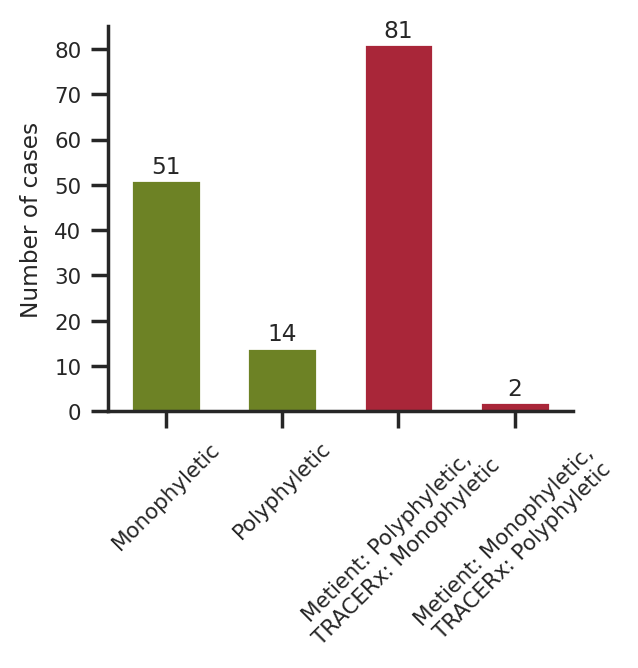

In [26]:
num_tracerx_mono_met_mono = len(tracerx_seeding[(tracerx_seeding['tracerx_multitree_adjustment']=="monophyletic")&(tracerx_seeding['metient_tracerx_phyletics'].str.contains("monophyletic"))])
print("tracerx mono met mono", (num_tracerx_mono_met_mono))
num_tracerx_mono_met_poly = len(tracerx_seeding[(tracerx_seeding['tracerx_multitree_adjustment']=="monophyletic")&(tracerx_seeding['metient_tracerx_phyletics'].str.contains("polyphyletic"))])
print("tracerx mono met poly", (num_tracerx_mono_met_poly))
num_tracerx_poly_met_poly = len(tracerx_seeding[(tracerx_seeding['tracerx_multitree_adjustment']=="polyphyletic")&(tracerx_seeding['metient_tracerx_phyletics'].str.contains("polyphyletic"))])
print("tracerx poly met poly", (num_tracerx_poly_met_poly))
num_tracerx_poly_met_mono = len(tracerx_seeding[(tracerx_seeding['tracerx_multitree_adjustment']=="polyphyletic")&(tracerx_seeding['metient_tracerx_phyletics'].str.contains("monophyletic"))])
print(num_tracerx_poly_met_mono)
print("tracerx poly met mono", (num_tracerx_poly_met_mono))


data = [["Monophyletic", num_tracerx_mono_met_mono], 
        ["Polyphyletic",num_tracerx_poly_met_poly], 
        ["Metient: Polyphyletic, \nTRACERx: Monophyletic",num_tracerx_mono_met_poly],
        ["Metient: Monophyletic, \nTRACERx: Polyphyletic",num_tracerx_poly_met_mono],]
df = pd.DataFrame( data,columns=["Method", "Number of cases"])
sns.set(font_scale=0.7)
sns.set_style("whitegrid")
sns.set_style("ticks")
sns.despine()
fig = plt.figure(figsize=(3, 2.5), dpi=200)
sns.set_palette(sns.color_palette(["#759116", "#759116", "#bf1029", "#bf1029"]))
ax = sns.barplot(df, x="Method", y="Number of cases", width=0.6, hue="Method")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 5), 
                textcoords='offset points')
# Add labels and legend
plt.xlabel("")
plt.ylabel("Number of cases")
plt.xticks(rotation=45)
fig.savefig(os.path.join(REPO_DIR, "metient/test/output_plots/tracerx", f"phyletic_consensus_{PARAMS}.png"), dpi=600, bbox_inches='tight', pad_inches=0.5) 


### How concordant are our characterizations of single-source/multi-source with TRACERx (which assumes primary single-source)

126
primary single-source    101
multi-source              12
single-source             10
reseeding                  2
no seeding                 1
Name: source, dtype: int64
                  Source  Counts
0  primary single-source     101
1           multi-source      12
2          single-source      10
3              reseeding       2
4             no seeding       1


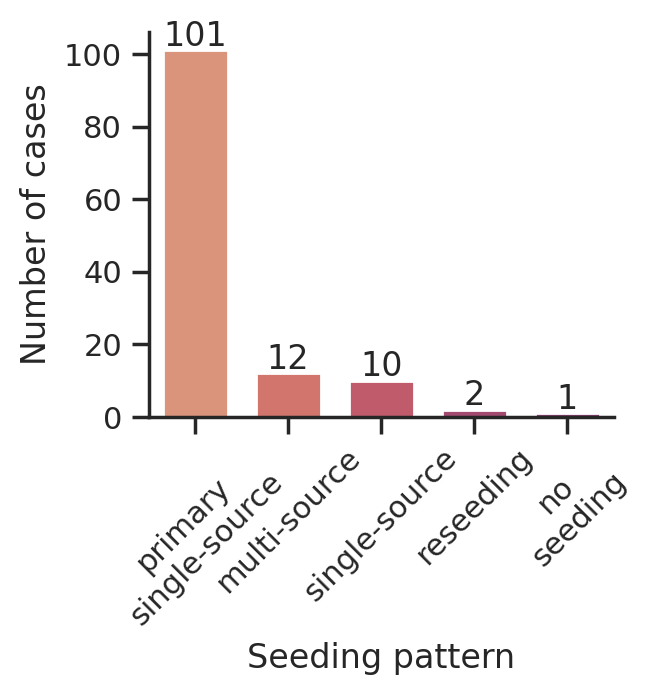

In [29]:
data = {"mono_poly" : [], "source" : [], "patient":[]}

    
for key, (patterns, tracerx_patterns) in inferred_patterns.items():
    patient = key.split("_")[0]
    pattern = patterns[0]
    data["patient"].append(patient)
    data["mono_poly"].append(pattern.split()[0])
    data["source"].append(get_source(pattern))
print(len(data["source"]))
# Create a DataFrame
top_pattern_df = pd.DataFrame(data)
print(top_pattern_df['source'].value_counts())
top_counts = top_pattern_df['source'].value_counts().reset_index()
top_counts.columns = ['Source', 'Counts']
sns.set(font_scale=1.0)
sns.set_style("whitegrid")
sns.set_style("ticks")
#sns.set_palette(sns.color_palette(["#6aa84f", "#c27ba0", "#e69138", "#6fa8dc"]))
sns.set_palette(sns.color_palette("flare"))
print(top_counts)
custom_labels = ["\n".join(label.split()) for label in top_pattern_df['source'].value_counts().index]
fig = plt.figure(figsize=(3, 2.5), dpi=200)

ax = sns.barplot(top_counts,x='Source',y='Counts', width=0.7, hue="Source")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 5), 
                textcoords='offset points')

    

plt.xlabel("Seeding pattern")
plt.ylabel("Number of cases")
plt.xticks(rotation=45, ticks=range(len(custom_labels)), labels=custom_labels)
plt.savefig(os.path.join(REPO_DIR, "metient/test/output_plots/tracerx", f"verbose_source_distribution_{PARAMS}.png"), dpi=600, bbox_inches='tight', pad_inches=0.5) 
plt.show()


[101, 109] [25, 17]


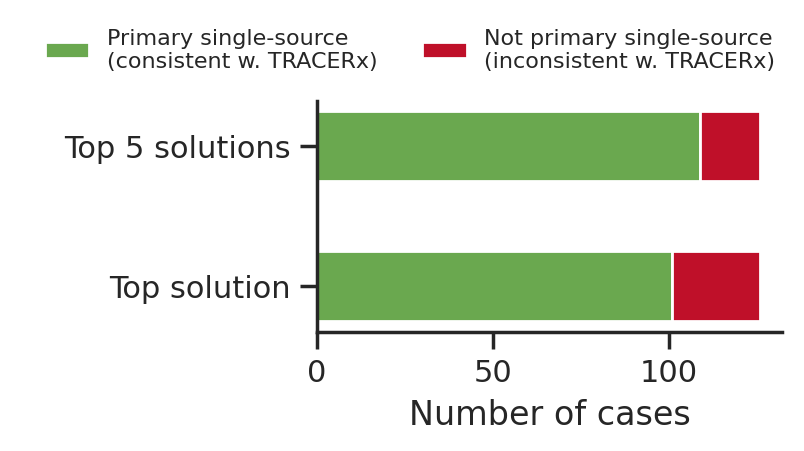

In [31]:
# Create a horizontal stacked bar chart using Seaborn

topk_prim_single_source = len(tracerx_seeding[(tracerx_seeding['metient_sources'].str.contains("primary single-source"))])

fig = plt.figure(figsize=(3, 1.5), dpi=200)
sns.set(font_scale=1.0)
sns.set_style("whitegrid")
sns.set_style("ticks")
ax = fig.add_subplot(111)
ys = ['Top solution', f'Top {MAX_K} solutions']
top_prim_single_source_count = top_counts[top_counts['Source']=='primary single-source']['Counts'].item()
prim_single_source_counts = [top_prim_single_source_count, topk_prim_single_source]
not_prim_single_source_counts = [len(inferred_patterns)-x for x in prim_single_source_counts]
print(prim_single_source_counts, not_prim_single_source_counts)
ax.barh(ys, prim_single_source_counts, align='center', height=.5, color='#6aa84f',label='Primary single-source\n(consistent w. TRACERx)')
ax.barh(ys, not_prim_single_source_counts, align='center', height=.5, left=prim_single_source_counts, color="#bf1029",label='Not primary single-source\n(inconsistent w. TRACERx)')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(ncol=2, loc='upper center', bbox_to_anchor=(0.2, 1.4), frameon=False, fontsize=8)

plt.xlabel("Number of cases")
plt.ylabel("  ")
#plt.xticks(rotation=0, ticks=range(len(custom_labels)), labels=custom_labels)
plt.savefig(os.path.join(REPO_DIR, "metient/test/output_plots/tracerx", f"concordance_prim_single_source_{PARAMS}.png"), dpi=600, bbox_inches='tight', pad_inches=0.5) 
plt.show()
